<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import misc

# Division 1

In [63]:
df1 = pd.read_csv('timing_data/div1.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div1'], thousands=',')
df2 = pd.read_csv('timing_data/div2.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div2'], thousands=',')
df3 = pd.read_csv('timing_data/div4.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div4'], thousands=',')

df = pd.concat([df1, df2, df3], sort=False, axis=1)
df = df.apply(lambda x: x.str.replace(',','').apply(pd.to_numeric))
df.head()

,Div1,Div2,Div4
0,0.008992,0.011816,0.007842
1,0.009904,0.016998,0.016450
2,0.051939,0.056280,0.021690
3,0.017205,0.011060,0.009204
4,0.011277,0.020402,0.021365


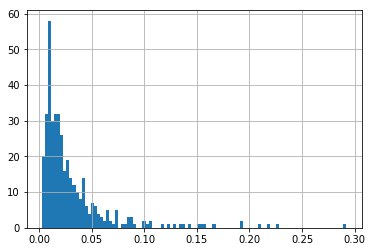

In [62]:
df['Div1'].hist(bins=100)

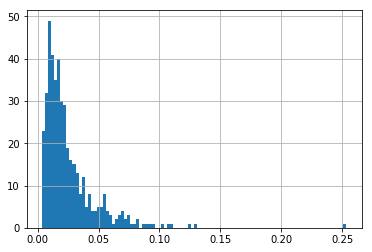

In [54]:
df['Div2'].hist(bins=100)

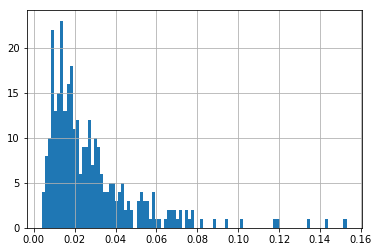

In [56]:
df['Div4'].hist(bins=100)

In [60]:
print('Division 1 {}'.format(df['Div1'].mean()))
print('Division 2 {}'.format(df['Div2'].mean()))
print('Division 4 {}'.format(df['Div4'].mean()))

Division 1 0.03160040861474875
Division 2 0.025461604321990846
Division 4 0.028192257117770715
